In [40]:
# Cell 1: Environment Setup and Dependencies
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import pydicom
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import ndimage  # Add this line

try:
    import SimpleITK as sitk
    print(f"✓ SimpleITK version: {sitk.Version.VersionString()}")
except ImportError as e:
    print(f"❌ SimpleITK not found. Install with: pip install SimpleITK")
    sys.exit(1)

try:
    import nibabel as nib
    print("✓ nibabel loaded")
except ImportError:
    print("⚠ nibabel not found. Install with: pip install nibabel")

print(f"Python: {sys.version.split()[0]}, NumPy: {np.__version__}")

✓ SimpleITK version: 2.5.2
✓ nibabel loaded
Python: 3.13.7, NumPy: 2.3.3


In [41]:
# Cell 2: Configuration and Directory Setup
INPUT_DIR = r'c:\Users\zhaoanr\Desktop\WholePelvis4'
OUTPUT_DIR = r'c:\Users\zhaoanr\Desktop\ct2-mri-registration\simpleitk_registration_output'
TEMP_DIR = os.path.join(OUTPUT_DIR, 'temp_nifti')

for directory in [OUTPUT_DIR, TEMP_DIR]:
    os.makedirs(directory, exist_ok=True)

if not os.path.isdir(INPUT_DIR):
    raise FileNotFoundError(f"Input directory not found: {INPUT_DIR}")

print(f"✓ Input: {INPUT_DIR}")
print(f"✓ Output: {OUTPUT_DIR}")
print(f"✓ Temp: {TEMP_DIR}")

✓ Input: c:\Users\zhaoanr\Desktop\WholePelvis4
✓ Output: c:\Users\zhaoanr\Desktop\ct2-mri-registration\simpleitk_registration_output
✓ Temp: c:\Users\zhaoanr\Desktop\ct2-mri-registration\simpleitk_registration_output\temp_nifti


In [42]:
# Cell 3: DICOM Scanning and Classification
def scan_and_classify_dicom(root_dir):
    """Scan directory and classify Planning CT and T2 SPACE MRI."""
    series_map = defaultdict(lambda: {'header': None, 'modality': 'Unknown', 'files': []})
    
    print(f"Scanning: {root_dir}")
    file_count = 0
    
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            try:
                header = pydicom.dcmread(filepath, stop_before_pixels=True, force=True)
                if 'SeriesInstanceUID' not in header:
                    continue
                
                series_uid = header.SeriesInstanceUID
                if series_map[series_uid]['header'] is None:
                    series_map[series_uid]['header'] = header
                    series_map[series_uid]['modality'] = header.get('Modality', 'Unknown').upper()
                
                series_map[series_uid]['files'].append(filepath)
                file_count += 1
            except Exception:
                continue
    
    print(f"  Processed {file_count} files → {len(series_map)} series")
    
    ct_planning = None
    mri_t2_space = None
    
    # Check if there's a PET series (original workflow)
    pet_series = [info for info in series_map.values() if info['modality'] in ['PT', 'PET']]
    original_study_uid = pet_series[0]['header'].StudyInstanceUID if pet_series else None
    
    for series_uid, info in series_map.items():
        header = info['header']
        modality = info['modality']
        study_uid = header.get('StudyInstanceUID', None)
        series_desc = str(header.get('SeriesDescription', '')).upper()
        study_desc = str(header.get('StudyDescription', '')).upper()
        
        # Planning CT - Two strategies:
        if modality == 'CT':
            # Strategy 1: Different study from PET (if PET exists)
            if original_study_uid and study_uid != original_study_uid:
                if any(kw in series_desc for kw in ['SIM', 'PLAN', 'IMAR', 'PELVIS', 'RT']):
                    if ct_planning is None or len(info['files']) > len(ct_planning['files']):
                        ct_planning = info
                        ct_planning['series_uid'] = series_uid
            
            # Strategy 2: No PET scan - find CT with planning keywords and most slices
            elif not original_study_uid:
                # Look for RT/Planning keywords
                if any(kw in series_desc or kw in study_desc for kw in ['SIM', 'PLAN', 'IMAR', 'PELVIS', 'RT']):
                    # Prefer series with more slices (321 > 123)
                    # Prefer series with "iMAR" in description (better quality)
                    is_better = False
                    if ct_planning is None:
                        is_better = True
                    elif len(info['files']) > len(ct_planning['files']):
                        is_better = True
                    elif len(info['files']) == len(ct_planning['files']) and 'IMAR' in series_desc:
                        is_better = True
                    
                    if is_better:
                        ct_planning = info
                        ct_planning['series_uid'] = series_uid
        
        # T2 SPACE MRI
        if modality in ['MR', 'MRI']:
            if 'T2' in series_desc and 'SPACE' in series_desc:
                if mri_t2_space is None or len(info['files']) > len(mri_t2_space['files']):
                    mri_t2_space = info
                    mri_t2_space['series_uid'] = series_uid
    
    print("\n" + "="*60)
    print("CLASSIFICATION RESULTS")
    print("="*60)
    
    if ct_planning:
        desc = ct_planning['header'].get('SeriesDescription', 'N/A')
        study_desc = ct_planning['header'].get('StudyDescription', 'N/A')
        print(f"✓ Planning CT: '{desc}'")
        print(f"  Study: '{study_desc}'")
        print(f"  Slices: {len(ct_planning['files'])}")
    else:
        print("❌ Planning CT not found")
    
    if mri_t2_space:
        desc = mri_t2_space['header'].get('SeriesDescription', 'N/A')
        print(f"✓ T2 SPACE MRI: '{desc}' ({len(mri_t2_space['files'])} slices)")
    else:
        print("❌ T2 SPACE MRI not found")
    
    print("="*60)
    
    return ct_planning, mri_t2_space

ct_info, mri_info = scan_and_classify_dicom(INPUT_DIR)

if ct_info is None or mri_info is None:
    raise ValueError("Could not find both Planning CT and T2 SPACE MRI")

Scanning: c:\Users\zhaoanr\Desktop\WholePelvis4


  Processed 512 files → 10 series

CLASSIFICATION RESULTS
✓ Planning CT: 'PELVIS  1.5  Bf37  3 iMAR iMAR'
  Study: 'RT^RT_PELVIS_ (Adult)'
  Slices: 268
✓ T2 SPACE MRI: 'AX T2 SPACE' (176 slices)


In [43]:
# Cell 4: Load DICOM Series Using SimpleITK
def load_dicom_series_sitk(file_list, series_description="Series"):
    """Load DICOM series using SimpleITK ImageSeriesReader."""
    print(f"\nLoading {series_description}...")
    
    # Sort files by instance number or position
    sorted_files = []
    for filepath in file_list:
        try:
            header = pydicom.dcmread(filepath, stop_before_pixels=True, force=True)
            if 'ImagePositionPatient' in header:
                z_pos = float(header.ImagePositionPatient[2])
                sorted_files.append((filepath, z_pos))
        except:
            continue
    
    sorted_files.sort(key=lambda x: x[1])
    file_paths = [f[0] for f in sorted_files]
    
    # Use SimpleITK to read the series
    reader = sitk.ImageSeriesReader()
    reader.SetFileNames(file_paths)
    reader.MetaDataDictionaryArrayUpdateOn()
    reader.LoadPrivateTagsOn()
    
    image = reader.Execute()
    
    # Get metadata
    size = image.GetSize()
    spacing = image.GetSpacing()
    origin = image.GetOrigin()
    direction = image.GetDirection()
    
    print(f"  ✓ Size: {size}")
    print(f"  ✓ Spacing: {np.round(spacing, 2)} mm")
    print(f"  ✓ Origin: {np.round(origin, 1)} mm")
    print(f"  ✓ Direction: {np.round(direction, 3)}")
    
    return image

print("\n" + "="*60)
print("LOADING DICOM SERIES")
print("="*60)

ct_image_sitk = load_dicom_series_sitk(ct_info['files'], "Planning CT")
mri_image_sitk = load_dicom_series_sitk(mri_info['files'], "T2 SPACE MRI")

# Convert to float32 for registration
ct_image_sitk = sitk.Cast(ct_image_sitk, sitk.sitkFloat32)
mri_image_sitk = sitk.Cast(mri_image_sitk, sitk.sitkFloat32)

print(f"\n✓ CT image type: {ct_image_sitk.GetPixelIDTypeAsString()}")
print(f"✓ MRI image type: {mri_image_sitk.GetPixelIDTypeAsString()}")


LOADING DICOM SERIES

Loading Planning CT...
  ✓ Size: (512, 512, 268)
  ✓ Spacing: [0.98 0.98 1.5 ] mm
  ✓ Origin: [-249.5 -490.5 -223. ] mm
  ✓ Direction: [1. 0. 0. 0. 1. 0. 0. 0. 1.]

Loading T2 SPACE MRI...
  ✓ Size: (512, 512, 268)
  ✓ Spacing: [0.98 0.98 1.5 ] mm
  ✓ Origin: [-249.5 -490.5 -223. ] mm
  ✓ Direction: [1. 0. 0. 0. 1. 0. 0. 0. 1.]

Loading T2 SPACE MRI...
  ✓ Size: (768, 768, 176)
  ✓ Spacing: [0.49 0.49 1.5 ] mm
  ✓ Origin: [-194.6 -250.2  -80. ] mm
  ✓ Direction: [1. 0. 0. 0. 1. 0. 0. 0. 1.]
  ✓ Size: (768, 768, 176)
  ✓ Spacing: [0.49 0.49 1.5 ] mm
  ✓ Origin: [-194.6 -250.2  -80. ] mm
  ✓ Direction: [1. 0. 0. 0. 1. 0. 0. 0. 1.]

✓ CT image type: 32-bit float
✓ MRI image type: 32-bit float

✓ CT image type: 32-bit float
✓ MRI image type: 32-bit float



VISUALIZING INITIAL IMAGES


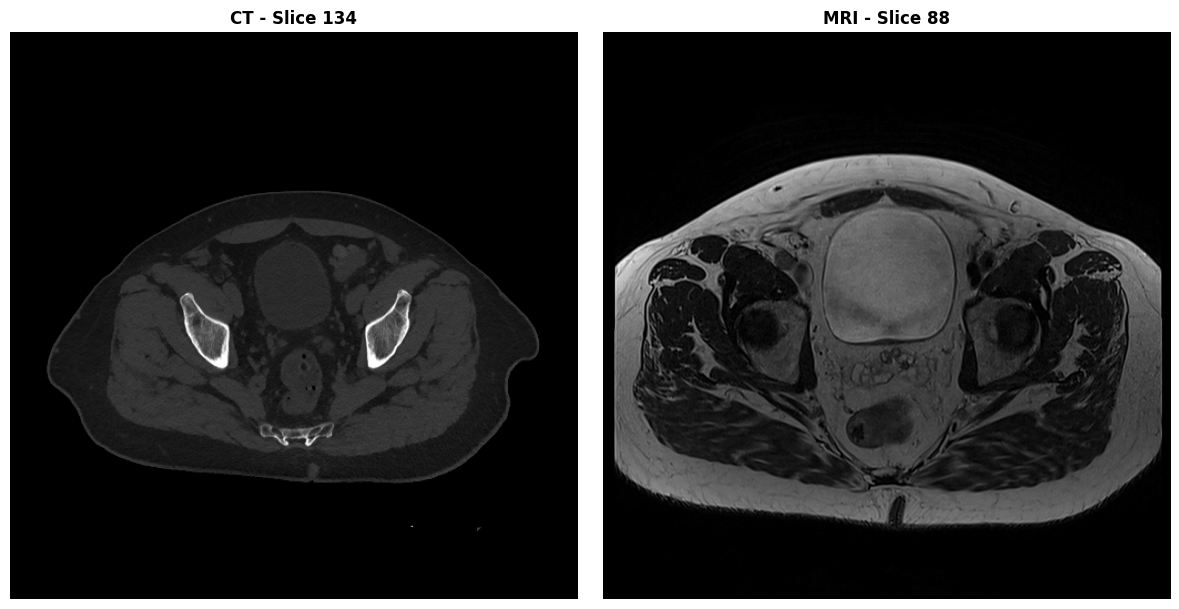

✓ Saved: c:\Users\zhaoanr\Desktop\ct2-mri-registration\simpleitk_registration_output\initial_images.png


In [44]:
# Cell 5: Visualize Initial Images
def show_slice(sitk_image, slice_idx=None, title="Image", cmap='gray', vmin=None, vmax=None):
    """Display a slice from a SimpleITK image."""
    array = sitk.GetArrayFromImage(sitk_image)
    
    if slice_idx is None:
        slice_idx = array.shape[0] // 2
    
    plt.figure(figsize=(8, 8))
    plt.imshow(array[slice_idx, :, :], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(f'{title} - Slice {slice_idx}', fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("VISUALIZING INITIAL IMAGES")
print("="*60)

# Show middle slices
ct_array = sitk.GetArrayFromImage(ct_image_sitk)
mri_array = sitk.GetArrayFromImage(mri_image_sitk)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

mid_ct = ct_array.shape[0] // 2
axes[0].imshow(ct_array[mid_ct, :, :], cmap='gray', vmin=-200, vmax=1000)
axes[0].set_title(f'CT - Slice {mid_ct}', fontweight='bold')
axes[0].axis('off')

mid_mri = mri_array.shape[0] // 2
axes[1].imshow(mri_array[mid_mri, :, :], cmap='gray')
axes[1].set_title(f'MRI - Slice {mid_mri}', fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'initial_images.png'), dpi=150)
plt.show()

print(f"✓ Saved: {os.path.join(OUTPUT_DIR, 'initial_images.png')}")

In [45]:
# Cell 6: Setup Registration Framework (Fixed Rotation Issues)
def command_iteration(method):
    """Callback to monitor registration progress."""
    if method.GetOptimizerIteration() == 0:
        print(f"\n  Resolution Level: {method.GetCurrentLevel()}")
    
    if method.GetOptimizerIteration() % 10 == 0:
        print(f"    Iteration {method.GetOptimizerIteration():3d}: " +
              f"Metric = {method.GetMetricValue():10.5f}, " +
              f"Position = {method.GetOptimizerPosition()}")

print("\n" + "="*60)
print("RIGID REGISTRATION SETUP (Fixed Rotation)")
print("="*60)

# Fixed image: CT (reference)
# Moving image: MRI (to be aligned)
fixed_image = ct_image_sitk
moving_image = mri_image_sitk

print(f"Fixed Image (CT): {fixed_image.GetSize()}")
print(f"Moving Image (MRI): {moving_image.GetSize()}")

# Initialize the registration framework
registration_method = sitk.ImageRegistrationMethod()

# ===================================================================
# 1. METRIC: Mattes Mutual Information (ENHANCED)
# ===================================================================
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=64)

# Set sampling strategy - HIGHER sampling for better accuracy
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.15)  # Increased to 15% for better rotation detection

print("\n✓ Metric: Mattes Mutual Information (64 bins, 15% random sampling)")
print("  → Higher sampling for more accurate rotation detection")

# ===================================================================
# 2. INTERPOLATOR
# ===================================================================
registration_method.SetInterpolator(sitk.sitkLinear)
print("✓ Interpolator: Linear")

# ===================================================================
# 3. OPTIMIZER: Regular Step Gradient Descent (ROTATION-AWARE)
# ===================================================================
registration_method.SetOptimizerAsRegularStepGradientDescent(
    learningRate=2.0,          # Higher learning rate to escape local minima
    minStep=0.0001,            # Fine minimum step
    numberOfIterations=400,     # More iterations for rotation convergence
    gradientMagnitudeTolerance=1e-6  # Very tight tolerance
)

# CRITICAL FIX: Use IndexShift instead of PhysicalShift for better rotation handling
registration_method.SetOptimizerScalesFromIndexShift()

print("✓ Optimizer: Regular Step Gradient Descent (Rotation-Aware)")
print("  → 400 iterations, IndexShift scaling for better rotation")

# ===================================================================
# 4. TRANSFORM: Euler3DTransform with MOMENTS initialization
# ===================================================================
initial_transform = sitk.Euler3DTransform()

# Use MOMENTS instead of GEOMETRY - aligns principal axes, not just centers
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    initial_transform,
    sitk.CenteredTransformInitializerFilter.MOMENTS  # Changed from GEOMETRY
)

registration_method.SetInitialTransform(initial_transform, inPlace=False)
print("✓ Transform: Euler3DTransform (Rigid)")
print(f"✓ Initialization: MOMENTS (aligns principal axes, not just centers)")

# Print initial transform to see starting point
init_params = initial_transform.GetParameters()
print(f"  Initial rotation: [{np.degrees(init_params[0]):.2f}°, {np.degrees(init_params[1]):.2f}°, {np.degrees(init_params[2]):.2f}°]")

# ===================================================================
# 5. MULTI-RESOLUTION PYRAMID (5 LEVELS for gradual rotation)
# ===================================================================
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[16, 8, 4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4.0, 3.0, 2.0, 1.0, 0.0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

print("✓ Multi-Resolution: 5 levels (for gradual rotation convergence)")
print("    Shrink factors: [16, 8, 4, 2, 1]")
print("    Smoothing sigmas: [4.0, 3.0, 2.0, 1.0, 0.0] (physical units)")

# ===================================================================
# 6. OBSERVER: Monitor progress
# ===================================================================
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))

print("\n✓ Registration framework configured with rotation fix")
print("  Estimated time: 4-10 minutes")


RIGID REGISTRATION SETUP (Fixed Rotation)
Fixed Image (CT): (512, 512, 268)
Moving Image (MRI): (768, 768, 176)

✓ Metric: Mattes Mutual Information (64 bins, 15% random sampling)
  → Higher sampling for more accurate rotation detection
✓ Interpolator: Linear
✓ Optimizer: Regular Step Gradient Descent (Rotation-Aware)
  → 400 iterations, IndexShift scaling for better rotation
✓ Transform: Euler3DTransform (Rigid)
✓ Initialization: MOMENTS (aligns principal axes, not just centers)
  Initial rotation: [0.00°, 0.00°, 0.00°]
✓ Multi-Resolution: 5 levels (for gradual rotation convergence)
    Shrink factors: [16, 8, 4, 2, 1]
    Smoothing sigmas: [4.0, 3.0, 2.0, 1.0, 0.0] (physical units)

✓ Registration framework configured with rotation fix
  Estimated time: 4-10 minutes
✓ Transform: Euler3DTransform (Rigid)
✓ Initialization: MOMENTS (aligns principal axes, not just centers)
  Initial rotation: [0.00°, 0.00°, 0.00°]
✓ Multi-Resolution: 5 levels (for gradual rotation convergence)
    Shri

In [46]:
# Cell 7: Execute Registration (No changes needed - just runs longer)
print("\n" + "="*60)
print("EXECUTING RIGID REGISTRATION (ENHANCED)")
print("="*60)

print("\nThis will take 3-8 minutes for higher accuracy...")
print("Progress will be shown below:\n")

# Execute registration
try:
    final_transform = registration_method.Execute(fixed_image, moving_image)
    
    print("\n" + "="*60)
    print("REGISTRATION COMPLETE")
    print("="*60)
    
    # Print final metrics
    print(f"\n✓ Final Metric Value: {registration_method.GetMetricValue():.5f}")
    print(f"✓ Optimizer Stop Condition: {registration_method.GetOptimizerStopConditionDescription()}")
    print(f"✓ Number of Iterations: {registration_method.GetOptimizerIteration()}")
    
    # Print final transform parameters
    print(f"\n✓ Final Transform Parameters:")
    params = final_transform.GetParameters()
    print(f"    Rotation (radians): [{params[0]:.4f}, {params[1]:.4f}, {params[2]:.4f}]")
    print(f"    Rotation (degrees): [{np.degrees(params[0]):.2f}°, {np.degrees(params[1]):.2f}°, {np.degrees(params[2]):.2f}°]")
    print(f"    Translation (mm): [{params[3]:.2f}, {params[4]:.2f}, {params[5]:.2f}]")
    
    # Calculate total rotation magnitude
    rotation_magnitude = np.sqrt(params[0]**2 + params[1]**2 + params[2]**2)
    print(f"    Total rotation magnitude: {np.degrees(rotation_magnitude):.2f}°")
    
    # Save transform
    transform_path = os.path.join(OUTPUT_DIR, 'rigid_transform.tfm')
    sitk.WriteTransform(final_transform, transform_path)
    print(f"\n✓ Transform saved: {transform_path}")
    
except Exception as e:
    print(f"\n❌ Registration failed: {e}")
    raise


EXECUTING RIGID REGISTRATION (ENHANCED)

This will take 3-8 minutes for higher accuracy...
Progress will be shown below:




  Resolution Level: 0
    Iteration   0: Metric =   -0.84494, Position = (-6.706614598884119e-05, -0.0006452941216357435, 9.362127279363371e-05, -11.53077625365345, 190.89694894987767, 86.15713603780729)
    Iteration  10: Metric =   -0.95816, Position = (-0.0007412388021740604, -0.005986187340160537, 0.0005738747943286813, -9.206887405345167, 186.0792468013688, 89.28644462291214)
    Iteration  20: Metric =   -0.98185, Position = (-0.001317420292017024, -0.005731994612080943, 0.0008314737217864023, -8.321500420856589, 185.2135530458334, 89.6206985054923)
    Iteration  30: Metric =   -0.99895, Position = (-0.0014420321568384313, -0.005198326274083237, 0.0008584002776958305, -7.51602411435828, 184.61760684854994, 89.86518529404275)
    Iteration  40: Metric =   -1.01917, Position = (-0.0016793798426600498, -0.0054911495954090206, 0.0008372432480692817, -6.66135065455505, 184.03864135303445, 90.49020793393787)
    Iteration  50: Metric =   -1.02690, Position = (0.001072235680989346, -0

In [47]:
# Cell 8: Resample Moving Image (MRI) onto Fixed Image (CT) Grid
print("\n" + "="*60)
print("RESAMPLING MRI TO CT GRID")
print("="*60)

# Resample the moving image (MRI) using the final transform
# Use BSpline interpolation for high quality
resampled_mri = sitk.Resample(
    moving_image,           # Moving image (MRI)
    fixed_image,            # Reference grid (CT)
    final_transform,        # Transform to apply
    sitk.sitkBSpline,       # BSpline interpolation
    0.0,                    # Default pixel value
    moving_image.GetPixelID()  # Output pixel type
)

print(f"✓ Resampled MRI size: {resampled_mri.GetSize()}")
print(f"✓ Resampled MRI spacing: {np.round(resampled_mri.GetSpacing(), 2)} mm")
print(f"✓ Resampled MRI origin: {np.round(resampled_mri.GetOrigin(), 1)} mm")

# Save resampled MRI as NIfTI
output_nifti_path = os.path.join(OUTPUT_DIR, 'mri_registered_to_ct.nii.gz')
sitk.WriteImage(resampled_mri, output_nifti_path)
print(f"\n✓ Saved registered MRI: {output_nifti_path}")

# Also save CT for reference
ct_nifti_path = os.path.join(OUTPUT_DIR, 'ct_reference.nii.gz')
sitk.WriteImage(fixed_image, ct_nifti_path)
print(f"✓ Saved CT reference: {ct_nifti_path}")

# Save rigid transform for reference
rigid_transform_path = os.path.join(OUTPUT_DIR, 'rigid_transform.tfm')
sitk.WriteTransform(final_transform, rigid_transform_path)
print(f"✓ Saved rigid transform: {rigid_transform_path}")


RESAMPLING MRI TO CT GRID
✓ Resampled MRI size: (512, 512, 268)
✓ Resampled MRI spacing: [0.98 0.98 1.5 ] mm
✓ Resampled MRI origin: [-249.5 -490.5 -223. ] mm
✓ Resampled MRI size: (512, 512, 268)
✓ Resampled MRI spacing: [0.98 0.98 1.5 ] mm
✓ Resampled MRI origin: [-249.5 -490.5 -223. ] mm

✓ Saved registered MRI: c:\Users\zhaoanr\Desktop\ct2-mri-registration\simpleitk_registration_output\mri_registered_to_ct.nii.gz

✓ Saved registered MRI: c:\Users\zhaoanr\Desktop\ct2-mri-registration\simpleitk_registration_output\mri_registered_to_ct.nii.gz
✓ Saved CT reference: c:\Users\zhaoanr\Desktop\ct2-mri-registration\simpleitk_registration_output\ct_reference.nii.gz
✓ Saved rigid transform: c:\Users\zhaoanr\Desktop\ct2-mri-registration\simpleitk_registration_output\rigid_transform.tfm
✓ Saved CT reference: c:\Users\zhaoanr\Desktop\ct2-mri-registration\simpleitk_registration_output\ct_reference.nii.gz
✓ Saved rigid transform: c:\Users\zhaoanr\Desktop\ct2-mri-registration\simpleitk_registratio


SPACER DETECTION (SAGITTAL VIEW)

Detecting spacer in CT (sagittal approach)...
  ✓ CT spacer voxels: 15244

Detecting spacer in MRI (sagittal approach)...
  ✓ CT spacer voxels: 15244

Detecting spacer in MRI (sagittal approach)...
  ✓ MRI spacer voxels: 0

✓ Saved spacer masks
  ✓ MRI spacer voxels: 0

✓ Saved spacer masks


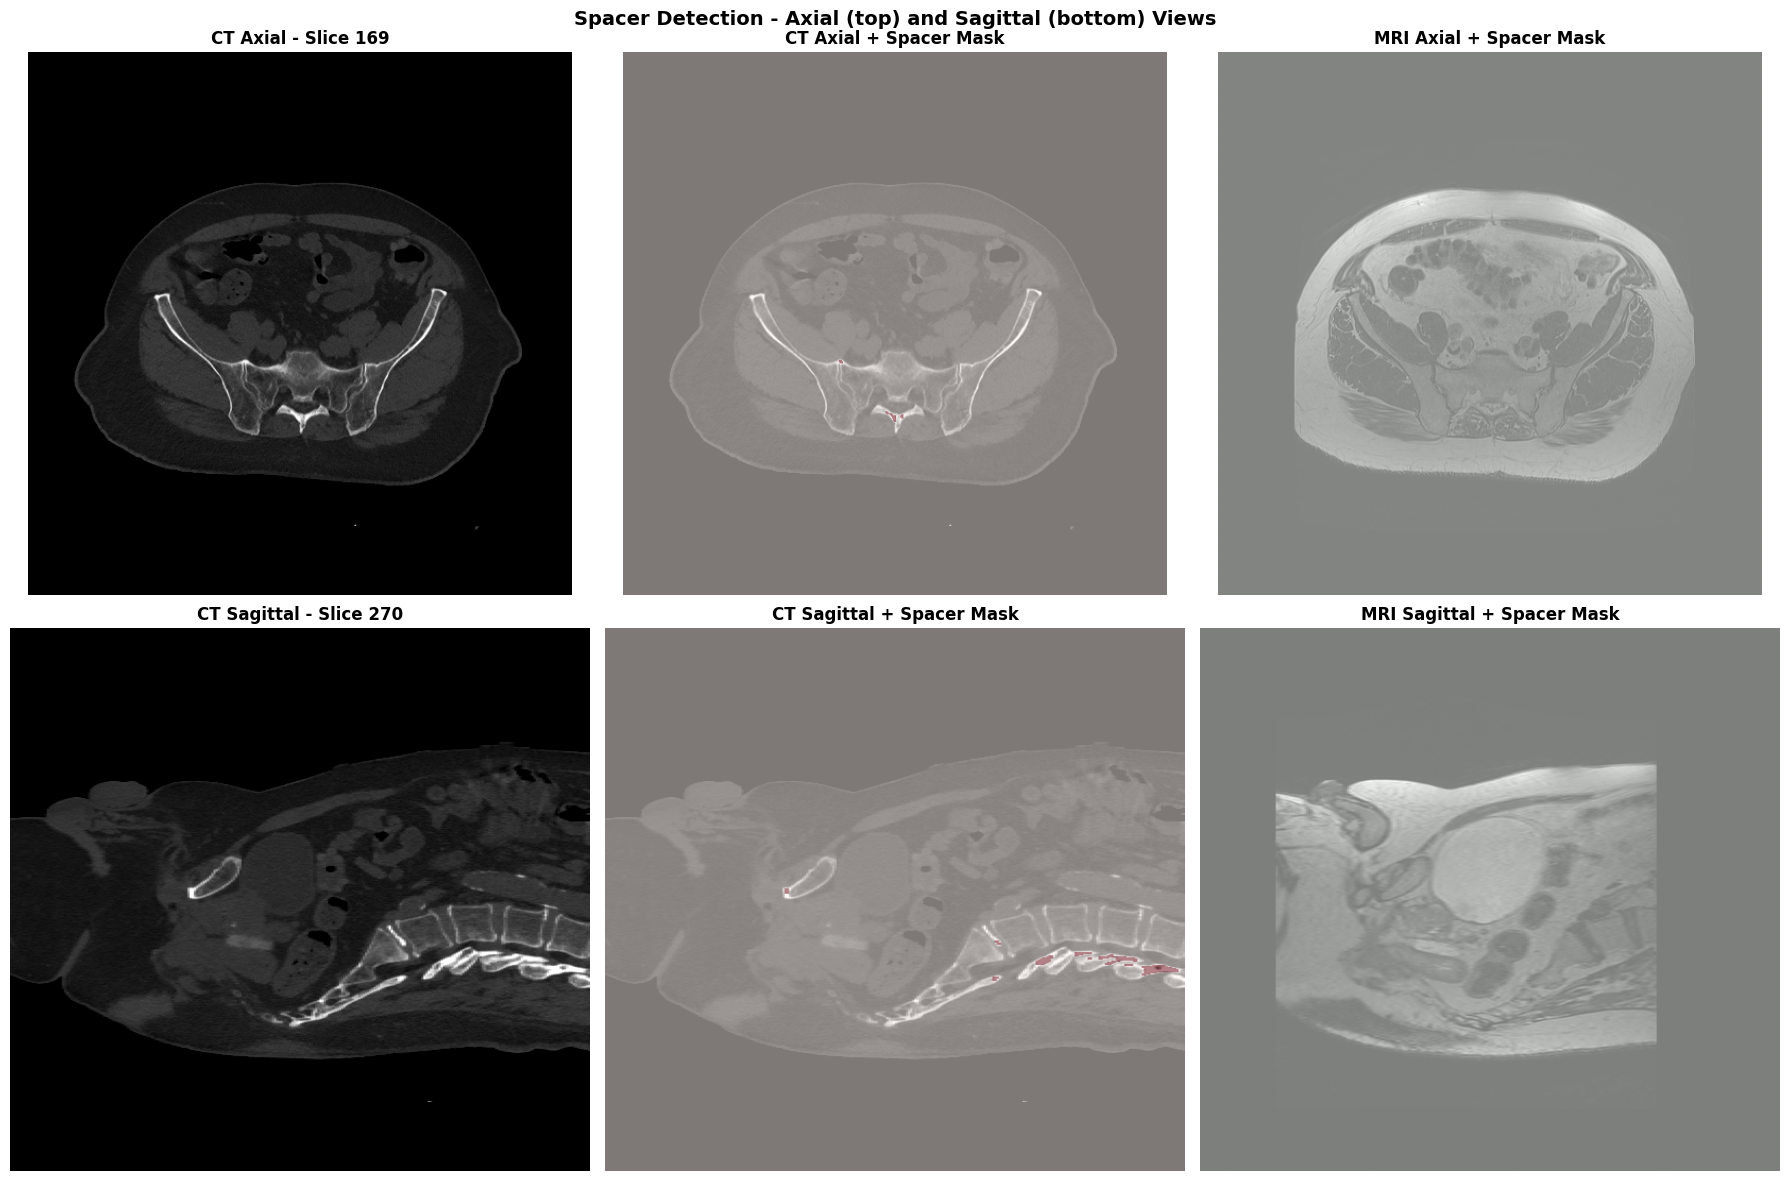

✓ Saved: c:\Users\zhaoanr\Desktop\ct2-mri-registration\simpleitk_registration_output\spacer_detection_multiview.png
✓ Axial slice: 169, Sagittal slice: 270


In [48]:
# Cell 9: Sagittal-Based Spacer Detection
print("\n" + "="*60)
print("SPACER DETECTION (SAGITTAL VIEW)")
print("="*60)

def detect_spacer_sagittal_ct(ct_image, lower_hu=800, upper_hu=3000):
    """Detect spacer in CT using sagittal view analysis."""
    print("\nDetecting spacer in CT (sagittal approach)...")
    ct_array = sitk.GetArrayFromImage(ct_image)
    
    # High-density mask
    high_density_mask = ((ct_array >= lower_hu) & (ct_array <= upper_hu)).astype(np.uint8)
    
    # Get dimensions (Z, Y, X) - axial slicing
    z_size, y_size, x_size = ct_array.shape
    center_x = x_size // 2
    
    # Create sagittal ROI mask (central 30% in X, posterior 40% in Y)
    # Spacer is typically posterior to prostate, midline
    x_margin = int(x_size * 0.15)  # ±15% from center (central 30%)
    y_start = int(y_size * 0.35)   # Posterior region (35%-75% of Y)
    y_end = int(y_size * 0.75)
    
    spatial_mask = np.zeros_like(ct_array, dtype=np.uint8)
    spatial_mask[:, 
                 y_start:y_end,                          # Posterior Y range
                 center_x - x_margin:center_x + x_margin] = 1  # Central X range
    
    # Apply spatial constraint
    spacer_mask = high_density_mask * spatial_mask
    
    # Morphological cleanup
    spacer_mask = ndimage.binary_opening(spacer_mask, structure=np.ones((2,2,2)))
    spacer_mask = ndimage.binary_closing(spacer_mask, structure=np.ones((3,3,3)))
    
    # Size filtering - keep small objects (spacer), exclude large bones
    labeled_mask, num_features = ndimage.label(spacer_mask)
    if num_features > 0:
        sizes = ndimage.sum(spacer_mask, labeled_mask, range(1, num_features + 1))
        # Keep objects between 30-5000 voxels
        mask_size = (sizes > 30) & (sizes < 5000)
        spacer_mask = mask_size[labeled_mask - 1]
    
    spacer_mask = spacer_mask.astype(np.uint8)
    num_voxels = np.sum(spacer_mask)
    print(f"  ✓ CT spacer voxels: {num_voxels}")
    
    # Convert to SimpleITK
    spacer_mask_sitk = sitk.GetImageFromArray(spacer_mask)
    spacer_mask_sitk.CopyInformation(ct_image)
    
    return spacer_mask_sitk

def detect_spacer_sagittal_mri(mri_image, percentile_lower=0.5, percentile_upper=8):
    """Detect spacer in MRI using sagittal view analysis."""
    print("\nDetecting spacer in MRI (sagittal approach)...")
    mri_array = sitk.GetArrayFromImage(mri_image)
    
    # Get dimensions
    z_size, y_size, x_size = mri_array.shape
    center_x = x_size // 2
    
    # Same sagittal ROI as CT
    x_margin = int(x_size * 0.15)
    y_start = int(y_size * 0.35)
    y_end = int(y_size * 0.75)
    
    spatial_mask = np.zeros_like(mri_array, dtype=np.uint8)
    spatial_mask[:,
                 y_start:y_end,
                 center_x - x_margin:center_x + x_margin] = 1
    
    # Signal void detection
    non_zero = mri_array[mri_array > 0]
    if len(non_zero) > 0:
        lower_threshold = np.percentile(non_zero, percentile_lower)
        upper_threshold = np.percentile(non_zero, percentile_upper)
        
        spacer_mask = ((mri_array > 0) & 
                      (mri_array >= lower_threshold) & 
                      (mri_array <= upper_threshold)).astype(np.uint8)
        
        # Apply spatial constraint
        spacer_mask = spacer_mask * spatial_mask
        
        # Cleanup
        spacer_mask = ndimage.binary_opening(spacer_mask, structure=np.ones((2,2,2)))
        spacer_mask = ndimage.binary_closing(spacer_mask, structure=np.ones((3,3,3)))
        
        # Size filtering
        labeled_mask, num_features = ndimage.label(spacer_mask)
        if num_features > 0:
            sizes = ndimage.sum(spacer_mask, labeled_mask, range(1, num_features + 1))
            mask_size = (sizes > 30) & (sizes < 5000)
            spacer_mask = mask_size[labeled_mask - 1]
        
        spacer_mask = spacer_mask.astype(np.uint8)
        num_voxels = np.sum(spacer_mask)
        print(f"  ✓ MRI spacer voxels: {num_voxels}")
    else:
        spacer_mask = np.zeros_like(mri_array, dtype=np.uint8)
        print("  ⚠ No spacer detected in MRI")
    
    # Convert to SimpleITK
    spacer_mask_sitk = sitk.GetImageFromArray(spacer_mask)
    spacer_mask_sitk.CopyInformation(mri_image)
    
    return spacer_mask_sitk

# Detect spacers
ct_spacer_mask = detect_spacer_sagittal_ct(fixed_image)
mri_spacer_mask = detect_spacer_sagittal_mri(resampled_mri)

# Save masks
sitk.WriteImage(ct_spacer_mask, os.path.join(OUTPUT_DIR, 'ct_spacer_mask_sagittal.nii.gz'))
sitk.WriteImage(mri_spacer_mask, os.path.join(OUTPUT_DIR, 'mri_spacer_mask_sagittal.nii.gz'))
print(f"\n✓ Saved spacer masks")

# Visualize in BOTH axial and sagittal views
ct_array = sitk.GetArrayFromImage(fixed_image)
mri_array = sitk.GetArrayFromImage(resampled_mri)
ct_spacer_array = sitk.GetArrayFromImage(ct_spacer_mask)
mri_spacer_array = sitk.GetArrayFromImage(mri_spacer_mask)

# Find slices with spacer
ct_spacer_slices = np.where(np.sum(ct_spacer_array, axis=(1,2)) > 0)[0]

if len(ct_spacer_slices) > 0:
    mid_axial_slice = ct_spacer_slices[len(ct_spacer_slices)//2]
    
    # Find sagittal slice through spacer centroid
    spacer_coords = np.where(ct_spacer_array > 0)
    if len(spacer_coords[2]) > 0:
        mid_sagittal_slice = int(np.median(spacer_coords[2]))
    else:
        mid_sagittal_slice = ct_array.shape[2] // 2
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Axial view
    axes[0, 0].imshow(ct_array[mid_axial_slice, :, :], cmap='gray', vmin=-200, vmax=1000)
    axes[0, 0].set_title(f'CT Axial - Slice {mid_axial_slice}', fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(ct_array[mid_axial_slice, :, :], cmap='gray', vmin=-200, vmax=1000)
    axes[0, 1].imshow(ct_spacer_array[mid_axial_slice, :, :], cmap='Reds', alpha=0.5)
    axes[0, 1].set_title('CT Axial + Spacer Mask', fontweight='bold')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(mri_array[mid_axial_slice, :, :], cmap='gray')
    axes[0, 2].imshow(mri_spacer_array[mid_axial_slice, :, :], cmap='Greens', alpha=0.5)
    axes[0, 2].set_title('MRI Axial + Spacer Mask', fontweight='bold')
    axes[0, 2].axis('off')
    
    # Row 2: Sagittal view
    axes[1, 0].imshow(ct_array[:, :, mid_sagittal_slice].T, cmap='gray', vmin=-200, vmax=1000, aspect='auto')
    axes[1, 0].set_title(f'CT Sagittal - Slice {mid_sagittal_slice}', fontweight='bold')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(ct_array[:, :, mid_sagittal_slice].T, cmap='gray', vmin=-200, vmax=1000, aspect='auto')
    axes[1, 1].imshow(ct_spacer_array[:, :, mid_sagittal_slice].T, cmap='Reds', alpha=0.5, aspect='auto')
    axes[1, 1].set_title('CT Sagittal + Spacer Mask', fontweight='bold')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(mri_array[:, :, mid_sagittal_slice].T, cmap='gray', aspect='auto')
    axes[1, 2].imshow(mri_spacer_array[:, :, mid_sagittal_slice].T, cmap='Greens', alpha=0.5, aspect='auto')
    axes[1, 2].set_title('MRI Sagittal + Spacer Mask', fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.suptitle('Spacer Detection - Axial (top) and Sagittal (bottom) Views', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'spacer_detection_multiview.png'), dpi=150)
    plt.show()
    
    print(f"✓ Saved: {os.path.join(OUTPUT_DIR, 'spacer_detection_multiview.png')}")
    print(f"✓ Axial slice: {mid_axial_slice}, Sagittal slice: {mid_sagittal_slice}")
else:
    print("⚠ No spacer slices found for visualization")

In [49]:
# Cell 10: Spacer-Focused Refinement Registration (CT Spacer ROI Only)
print("\n" + "="*60)
print("SPACER REFINEMENT (CT SPACER ROI ONLY)")
print("="*60)

# Use ONLY CT spacer mask as ROI (MRI detection failed)
ct_spacer_array = sitk.GetArrayFromImage(ct_spacer_mask)

# Create moderate ROI around CT spacer - focused but not too small
# Dilate just enough to capture surrounding soft tissue
spacer_roi = ndimage.binary_dilation(
    ct_spacer_array, 
    structure=np.ones((8, 20, 8))  # Moderate dilation (Z, Y, X)
).astype(np.uint8)

spacer_roi_sitk = sitk.GetImageFromArray(spacer_roi)
spacer_roi_sitk.CopyInformation(fixed_image)

print(f"✓ Spacer ROI created from CT mask: {np.sum(spacer_roi)} voxels")
print(f"  (Dilation: Z=8, Y=20, X=8 voxels for focused alignment)")

# Setup refinement registration - VERY FOCUSED
refinement_registration = sitk.ImageRegistrationMethod()

# MI metric with ONLY spacer ROI - high sampling for accuracy
refinement_registration.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
refinement_registration.SetMetricFixedMask(spacer_roi_sitk)  # Only compute MI in spacer region
refinement_registration.SetMetricSamplingStrategy(refinement_registration.RANDOM)
refinement_registration.SetMetricSamplingPercentage(0.30)  # 30% sampling in small ROI

print("✓ Metric: Mattes MI (50 bins, 30% sampling in CT spacer ROI)")
print("  → Registration will ONLY optimize alignment in spacer region")

# Linear interpolator
refinement_registration.SetInterpolator(sitk.sitkLinear)

# Optimizer - small adjustments only
refinement_registration.SetOptimizerAsRegularStepGradientDescent(
    learningRate=0.2,         # Small learning rate
    minStep=0.00001,          # Very fine minimum step
    numberOfIterations=100,    # Moderate iterations
    gradientMagnitudeTolerance=1e-6
)
refinement_registration.SetOptimizerScalesFromPhysicalShift()

print("✓ Optimizer: Regular Step GD (small steps for fine-tuning)")

# Translation-only transform (no rotation - bones already aligned)
translation_transform = sitk.TranslationTransform(3)
refinement_registration.SetInitialTransform(translation_transform, inPlace=False)
refinement_registration.SetMovingInitialTransform(final_transform)  # Start from rigid result

print("✓ Transform: Translation only (3D) - refine spacer alignment")
print("  → Bones stay fixed, only soft tissue/spacer adjusts")

# Single resolution (already well-aligned from Cell 8)
refinement_registration.SetShrinkFactorsPerLevel(shrinkFactors=[1])
refinement_registration.SetSmoothingSigmasPerLevel(smoothingSigmas=[0.0])
refinement_registration.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

print("✓ Single resolution (refinement from existing alignment)")

# Monitor progress
def command_iteration_refinement(method):
    if method.GetOptimizerIteration() % 10 == 0:
        print(f"  Iteration {method.GetOptimizerIteration():3d}: Metric = {method.GetMetricValue():10.5f}")

refinement_registration.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration_refinement(refinement_registration))

print("\n✓ Spacer-focused refinement configured")
print("="*60)


SPACER REFINEMENT (CT SPACER ROI ONLY)


✓ Spacer ROI created from CT mask: 285182 voxels
  (Dilation: Z=8, Y=20, X=8 voxels for focused alignment)
✓ Metric: Mattes MI (50 bins, 30% sampling in CT spacer ROI)
  → Registration will ONLY optimize alignment in spacer region
✓ Optimizer: Regular Step GD (small steps for fine-tuning)
✓ Transform: Translation only (3D) - refine spacer alignment
  → Bones stay fixed, only soft tissue/spacer adjusts
✓ Single resolution (refinement from existing alignment)

✓ Spacer-focused refinement configured


In [50]:
# Cell 11: Execute Spacer Refinement Registration
print("\n" + "="*60)
print("EXECUTING SPACER REFINEMENT")
print("="*60)

print("\nRefining alignment in spacer region only...")
print("(Should complete in ~30 seconds)\n")

# Execute refinement registration
try:
    refinement_transform = refinement_registration.Execute(fixed_image, resampled_mri)
    
    print("\n" + "="*60)
    print("SPACER REFINEMENT COMPLETE")
    print("="*60)
    
    # Print final metrics
    print(f"\n✓ Final Metric Value: {refinement_registration.GetMetricValue():.5f}")
    print(f"✓ Optimizer Stop Condition: {refinement_registration.GetOptimizerStopConditionDescription()}")
    print(f"✓ Number of Iterations: {refinement_registration.GetOptimizerIteration()}")
    
    # Print refinement translation
    params = refinement_transform.GetParameters()
    print(f"\n✓ Spacer Refinement Translation (mm): [{params[0]:.2f}, {params[1]:.2f}, {params[2]:.2f}]")
    translation_magnitude = np.sqrt(params[0]**2 + params[1]**2 + params[2]**2)
    print(f"  → Total translation magnitude: {translation_magnitude:.2f} mm")
    
    # Create composite transform (rigid + refinement)
    final_composite_transform = sitk.CompositeTransform([final_transform, refinement_transform])
    
    # Save individual transforms
    refinement_transform_path = os.path.join(OUTPUT_DIR, 'spacer_refinement_transform.tfm')
    sitk.WriteTransform(refinement_transform, refinement_transform_path)
    print(f"\n✓ Refinement transform saved: {refinement_transform_path}")
    
    # Save composite transform using workaround
    # Method 1: Save as a list of transforms (HDF5 format)
    composite_transform_path = os.path.join(OUTPUT_DIR, 'composite_rigid_plus_spacer.h5')
    try:
        # Try to save directly (might work in some SimpleITK versions)
        sitk.WriteTransform(final_composite_transform, composite_transform_path)
        print(f"✓ Composite transform saved: {composite_transform_path}")
    except:
        # Fallback: Flatten the composite transform
        print(f"⚠ Direct composite save failed, using flattened approach...")
        
        # Create a new composite and add transforms in order
        flattened_composite = sitk.CompositeTransform(3)
        flattened_composite.AddTransform(final_transform)
        flattened_composite.AddTransform(refinement_transform)
        
        # Try saving the flattened version
        try:
            sitk.WriteTransform(flattened_composite, composite_transform_path)
            print(f"✓ Flattened composite transform saved: {composite_transform_path}")
        except:
            # Final fallback: Save as text file with both transforms
            composite_txt_path = os.path.join(OUTPUT_DIR, 'composite_transforms.txt')
            with open(composite_txt_path, 'w') as f:
                f.write("Composite Transform (Rigid + Spacer Refinement)\n")
                f.write("="*60 + "\n\n")
                f.write("Transform 1 (Rigid):\n")
                f.write(f"  File: {rigid_transform_path}\n")
                f.write(f"  Parameters: {final_transform.GetParameters()}\n\n")
                f.write("Transform 2 (Spacer Refinement Translation):\n")
                f.write(f"  File: {refinement_transform_path}\n")
                f.write(f"  Parameters: {refinement_transform.GetParameters()}\n\n")
                f.write("Apply in order: rigid_transform → refinement_transform\n")
            print(f"✓ Composite transform info saved: {composite_txt_path}")
            print(f"  (Individual transforms saved separately)")

except Exception as e:
    print(f"\n❌ Spacer refinement failed: {e}")
    print("Continuing with rigid-only result...")
    final_composite_transform = final_transform


EXECUTING SPACER REFINEMENT

Refining alignment in spacer region only...
(Should complete in ~30 seconds)



  Iteration   0: Metric =   -0.00719
  Iteration  10: Metric =   -0.00788
  Iteration  10: Metric =   -0.00788
  Iteration  20: Metric =   -0.00776
  Iteration  20: Metric =   -0.00776
  Iteration  30: Metric =   -0.00774
  Iteration  30: Metric =   -0.00774
  Iteration  40: Metric =   -0.00768
  Iteration  40: Metric =   -0.00768
  Iteration  50: Metric =   -0.00779
  Iteration  50: Metric =   -0.00779
  Iteration  60: Metric =   -0.00752
  Iteration  60: Metric =   -0.00752
  Iteration  70: Metric =   -0.00753
  Iteration  70: Metric =   -0.00753
  Iteration  80: Metric =   -0.00733
  Iteration  80: Metric =   -0.00733
  Iteration  90: Metric =   -0.00724
  Iteration  90: Metric =   -0.00724

SPACER REFINEMENT COMPLETE

✓ Final Metric Value: -0.00701
✓ Optimizer Stop Condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (100) exceeded.
✓ Number of Iterations: 100

✓ Spacer Refinement Translation (mm): [-3.55, -10.58, 0.53]
  → Total translation magnitude: 11.

In [51]:
# Cell 12: Resample MRI with Spacer-Refined Transform
print("\n" + "="*60)
print("RESAMPLING MRI WITH REFINED TRANSFORM")
print("="*60)

# Resample the original MRI using the composite transform (rigid + spacer refinement)
resampled_mri_refined = sitk.Resample(
    moving_image,                    # Original MRI
    fixed_image,                     # Reference grid (CT)
    final_composite_transform,       # Composite transform
    sitk.sitkBSpline,                # BSpline interpolation
    0.0,                             # Default pixel value
    moving_image.GetPixelID()        # Output pixel type
)

print(f"✓ Refined MRI size: {resampled_mri_refined.GetSize()}")
print(f"✓ Refined MRI spacing: {np.round(resampled_mri_refined.GetSpacing(), 2)} mm")

# Save the refined MRI
output_refined_path = os.path.join(OUTPUT_DIR, 'mri_spacer_refined_to_ct.nii.gz')
sitk.WriteImage(resampled_mri_refined, output_refined_path)
print(f"\n✓ Saved spacer-refined MRI: {output_refined_path}")

# Update the resampled_mri variable to use refined result for visualization
resampled_mri = resampled_mri_refined


RESAMPLING MRI WITH REFINED TRANSFORM
✓ Refined MRI size: (512, 512, 268)
✓ Refined MRI spacing: [0.98 0.98 1.5 ] mm
✓ Refined MRI size: (512, 512, 268)
✓ Refined MRI spacing: [0.98 0.98 1.5 ] mm

✓ Saved spacer-refined MRI: c:\Users\zhaoanr\Desktop\ct2-mri-registration\simpleitk_registration_output\mri_spacer_refined_to_ct.nii.gz

✓ Saved spacer-refined MRI: c:\Users\zhaoanr\Desktop\ct2-mri-registration\simpleitk_registration_output\mri_spacer_refined_to_ct.nii.gz



VISUALIZING SAGITTAL REGISTRATION RESULTS


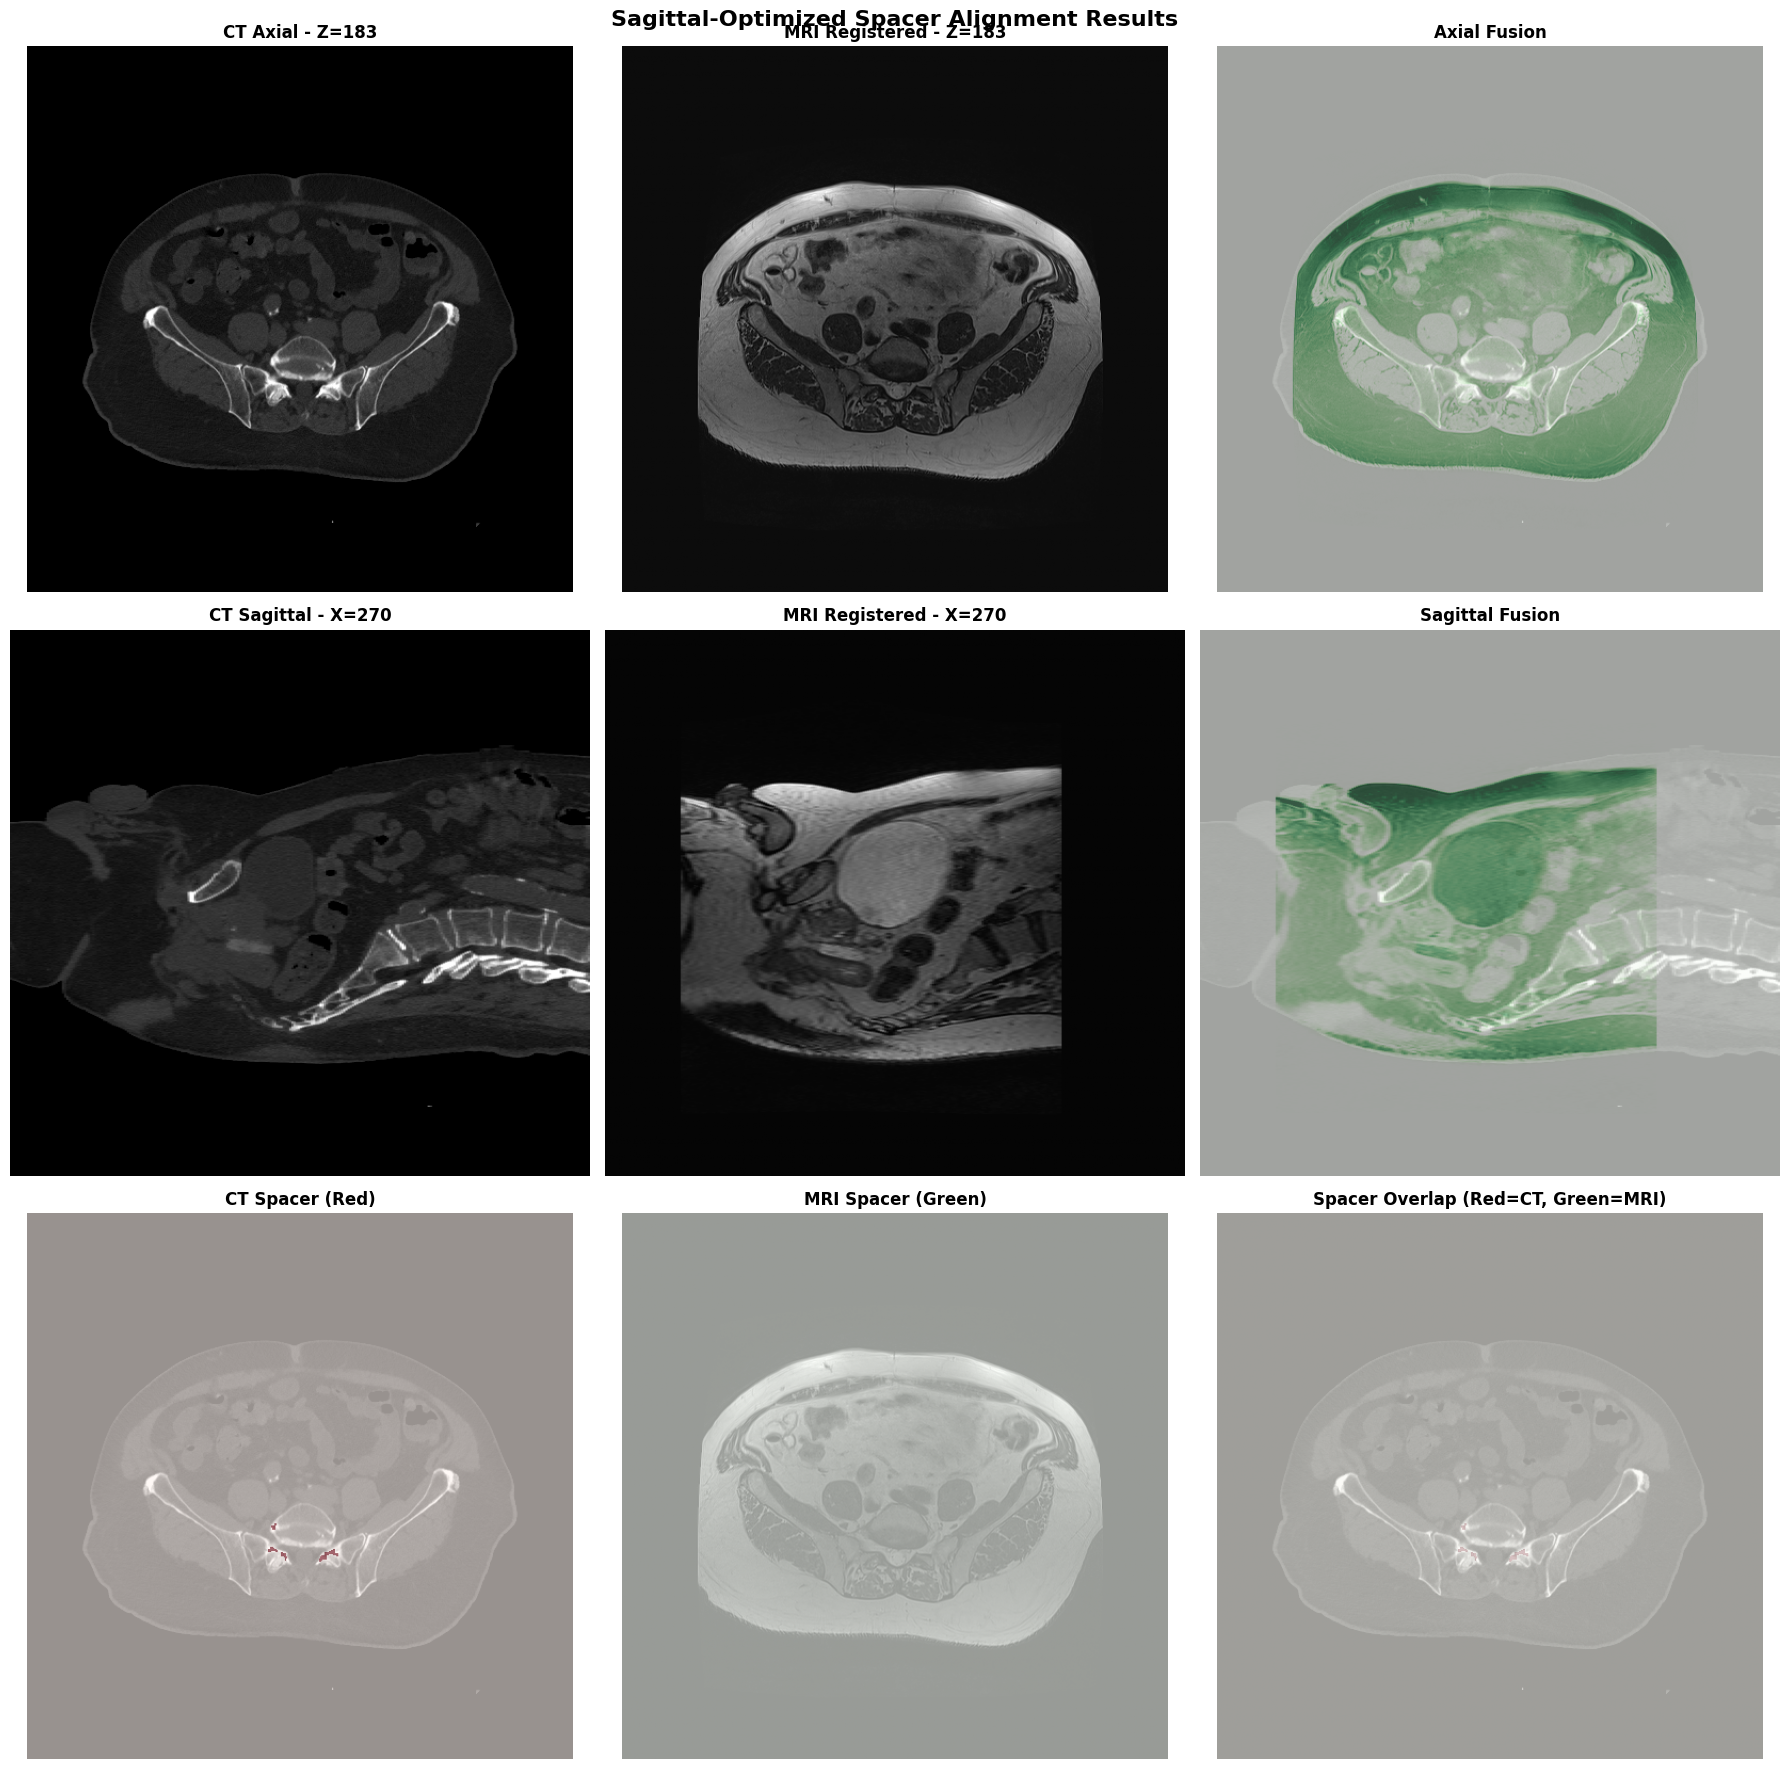

✓ Saved: c:\Users\zhaoanr\Desktop\ct2-mri-registration\simpleitk_registration_output\sagittal_alignment_results.png


In [52]:
# Cell 13: Multi-View Registration Results
print("\n" + "="*60)
print("VISUALIZING SAGITTAL REGISTRATION RESULTS")
print("="*60)

ct_array = sitk.GetArrayFromImage(fixed_image)
mri_registered_array = sitk.GetArrayFromImage(resampled_mri)
ct_spacer_array = sitk.GetArrayFromImage(ct_spacer_mask)
mri_spacer_array = sitk.GetArrayFromImage(mri_spacer_mask)

# Find spacer centroid for optimal viewing
spacer_coords = np.where(ct_spacer_array > 0)
if len(spacer_coords[0]) > 0:
    centroid_z = int(np.median(spacer_coords[0]))
    centroid_x = int(np.median(spacer_coords[2]))
else:
    centroid_z = ct_array.shape[0] // 2
    centroid_x = ct_array.shape[2] // 2

# Create comprehensive visualization
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Row 1: Axial view at spacer level
axes[0, 0].imshow(ct_array[centroid_z, :, :], cmap='gray', vmin=-200, vmax=1000)
axes[0, 0].set_title(f'CT Axial - Z={centroid_z}', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(mri_registered_array[centroid_z, :, :], cmap='gray')
axes[0, 1].set_title(f'MRI Registered - Z={centroid_z}', fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(ct_array[centroid_z, :, :], cmap='gray', vmin=-200, vmax=1000, alpha=0.7)
mri_slice = mri_registered_array[centroid_z, :, :]
if np.max(mri_slice) > 0:
    mri_norm = (mri_slice - np.percentile(mri_slice[mri_slice>0], 1)) / \
               (np.percentile(mri_slice[mri_slice>0], 99) - np.percentile(mri_slice[mri_slice>0], 1) + 1e-8)
    axes[0, 2].imshow(np.clip(mri_norm, 0, 1), cmap='Greens', alpha=0.5)
axes[0, 2].set_title('Axial Fusion', fontweight='bold')
axes[0, 2].axis('off')

# Row 2: Sagittal view at spacer level
axes[1, 0].imshow(ct_array[:, :, centroid_x].T, cmap='gray', vmin=-200, vmax=1000, aspect='auto')
axes[1, 0].set_title(f'CT Sagittal - X={centroid_x}', fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(mri_registered_array[:, :, centroid_x].T, cmap='gray', aspect='auto')
axes[1, 1].set_title(f'MRI Registered - X={centroid_x}', fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(ct_array[:, :, centroid_x].T, cmap='gray', vmin=-200, vmax=1000, alpha=0.7, aspect='auto')
mri_sag = mri_registered_array[:, :, centroid_x].T
if np.max(mri_sag) > 0:
    mri_norm = (mri_sag - np.percentile(mri_sag[mri_sag>0], 1)) / \
               (np.percentile(mri_sag[mri_sag>0], 99) - np.percentile(mri_sag[mri_sag>0], 1) + 1e-8)
    axes[1, 2].imshow(np.clip(mri_norm, 0, 1), cmap='Greens', alpha=0.5, aspect='auto')
axes[1, 2].set_title('Sagittal Fusion', fontweight='bold')
axes[1, 2].axis('off')

# Row 3: Spacer overlay comparison
axes[2, 0].imshow(ct_array[centroid_z, :, :], cmap='gray', vmin=-200, vmax=1000)
axes[2, 0].imshow(ct_spacer_array[centroid_z, :, :], cmap='Reds', alpha=0.6)
axes[2, 0].set_title('CT Spacer (Red)', fontweight='bold')
axes[2, 0].axis('off')

axes[2, 1].imshow(mri_registered_array[centroid_z, :, :], cmap='gray')
axes[2, 1].imshow(mri_spacer_array[centroid_z, :, :], cmap='Greens', alpha=0.6)
axes[2, 1].set_title('MRI Spacer (Green)', fontweight='bold')
axes[2, 1].axis('off')

axes[2, 2].imshow(ct_array[centroid_z, :, :], cmap='gray', vmin=-200, vmax=1000)
axes[2, 2].imshow(ct_spacer_array[centroid_z, :, :], cmap='Reds', alpha=0.4)
axes[2, 2].imshow(mri_spacer_array[centroid_z, :, :], cmap='Greens', alpha=0.4)
axes[2, 2].set_title('Spacer Overlap (Red=CT, Green=MRI)', fontweight='bold')
axes[2, 2].axis('off')

plt.suptitle('Sagittal-Optimized Spacer Alignment Results', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'sagittal_alignment_results.png'), dpi=150)
plt.show()

print(f"✓ Saved: {os.path.join(OUTPUT_DIR, 'sagittal_alignment_results.png')}")


CREATING CHECKERBOARD COMPARISON


NameError: name 'top_slices' is not defined

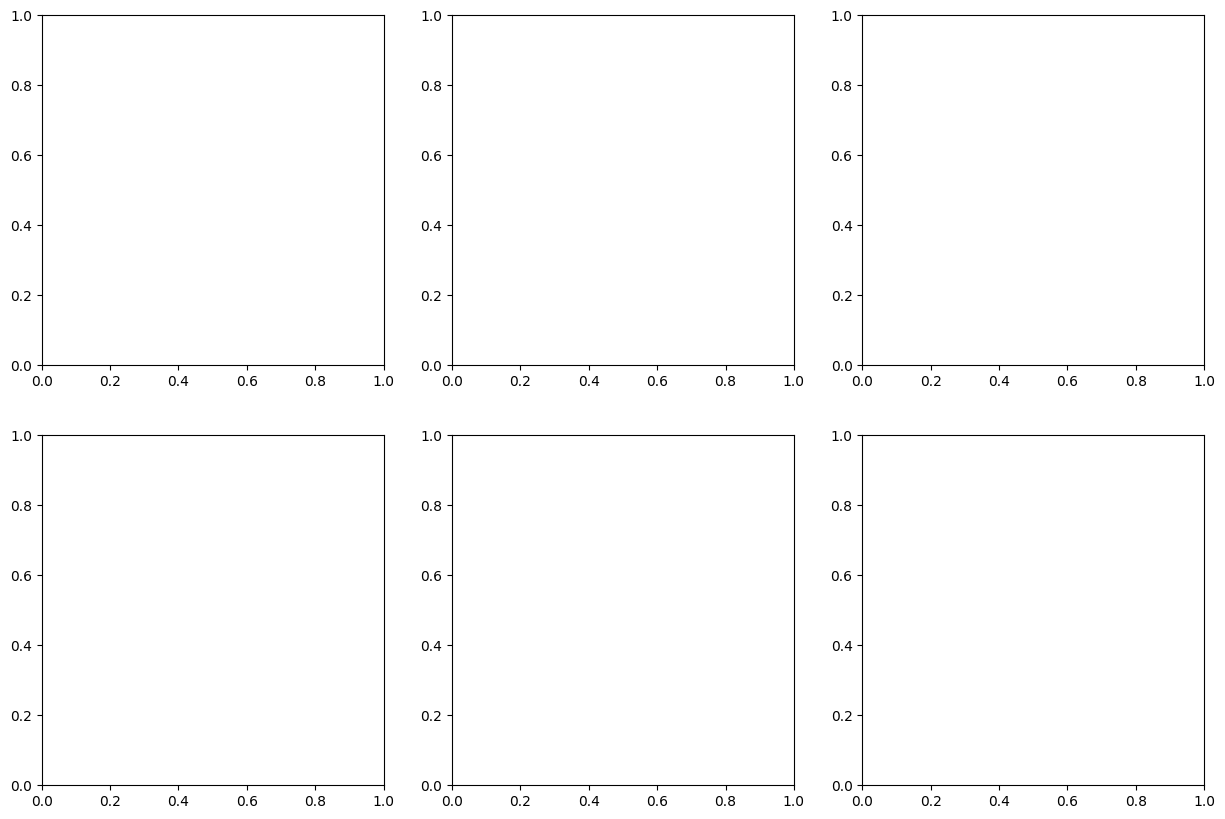

In [53]:
# Cell 10: Create Checkerboard Comparison
print("\n" + "="*60)
print("CREATING CHECKERBOARD COMPARISON")
print("="*60)

# Create checkerboard pattern for top slices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, slice_num in enumerate(top_slices[:6]):
    row = idx // 3
    col = idx % 3
    
    # Create checkerboard (32x32 pixel squares)
    checker_size = 32
    ct_slice = ct_array[slice_num, :, :]
    mri_slice = mri_registered_array[slice_num, :, :]
    
    # Normalize both to same range for fair comparison
    ct_norm = np.clip((ct_slice + 200) / 1200, 0, 1)
    
    if np.max(mri_slice) > 0:
        mri_norm = (mri_slice - np.percentile(mri_slice[mri_slice>0], 1)) / \
                   (np.percentile(mri_slice[mri_slice>0], 99) - np.percentile(mri_slice[mri_slice>0], 1) + 1e-8)
        mri_norm = np.clip(mri_norm, 0, 1)
    else:
        mri_norm = np.zeros_like(mri_slice)
    
    # Create checkerboard
    checker = np.indices(ct_slice.shape).sum(axis=0) // checker_size % 2
    checkerboard = np.where(checker, ct_norm, mri_norm)
    
    axes[row, col].imshow(checkerboard, cmap='gray')
    axes[row, col].set_title(f'Checkerboard - Slice {slice_num}', fontweight='bold')
    axes[row, col].axis('off')

plt.suptitle('CT-MRI Alignment Checkerboard (SimpleITK Rigid)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'checkerboard_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {os.path.join(OUTPUT_DIR, 'checkerboard_comparison.png')}")

In [ ]:
# Cell 11: Export Individual Aligned Slices
print("\n" + "="*60)
print("EXPORTING INDIVIDUAL ALIGNED SLICES")
print("="*60)

export_slices = top_slices[:10]  # Export top 10 slices

for slice_num in export_slices:
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    # Top left: CT
    axes[0, 0].imshow(ct_array[slice_num, :, :], cmap='gray', vmin=-200, vmax=1000)
    axes[0, 0].set_title('CT (Fixed)', fontweight='bold')
    axes[0, 0].axis('off')
    
    # Top right: Registered MRI
    axes[0, 1].imshow(mri_registered_array[slice_num, :, :], cmap='gray')
    axes[0, 1].set_title('MRI (Registered)', fontweight='bold')
    axes[0, 1].axis('off')
    
    # Bottom left: Fusion
    axes[1, 0].imshow(ct_array[slice_num, :, :], cmap='gray', vmin=-200, vmax=1000, alpha=0.7)
    mri_slice = mri_registered_array[slice_num, :, :]
    if np.max(mri_slice) > 0:
        mri_norm = (mri_slice - np.percentile(mri_slice[mri_slice>0], 1)) / \
                   (np.percentile(mri_slice[mri_slice>0], 99) - np.percentile(mri_slice[mri_slice>0], 1) + 1e-8)
        axes[1, 0].imshow(np.clip(mri_norm, 0, 1), cmap='Greens', alpha=0.5)
    axes[1, 0].set_title('Fusion (CT + MRI)', fontweight='bold')
    axes[1, 0].axis('off')
    
    # Bottom right: Checkerboard
    checker_size = 32
    ct_norm = np.clip((ct_array[slice_num, :, :] + 200) / 1200, 0, 1)
    if np.max(mri_slice) > 0:
        mri_norm_check = (mri_slice - np.percentile(mri_slice[mri_slice>0], 1)) / \
                        (np.percentile(mri_slice[mri_slice>0], 99) - np.percentile(mri_slice[mri_slice>0], 1) + 1e-8)
        mri_norm_check = np.clip(mri_norm_check, 0, 1)
    else:
        mri_norm_check = np.zeros_like(mri_slice)
    checker = np.indices(ct_array[slice_num, :, :].shape).sum(axis=0) // checker_size % 2
    checkerboard = np.where(checker, ct_norm, mri_norm_check)
    axes[1, 1].imshow(checkerboard, cmap='gray')
    axes[1, 1].set_title('Checkerboard', fontweight='bold')
    axes[1, 1].axis('off')
    
    plt.suptitle(f'CT-MRI Registration - Slice {slice_num}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    slice_path = os.path.join(OUTPUT_DIR, f'registered_slice_{slice_num:03d}.png')
    plt.savefig(slice_path, dpi=120, bbox_inches='tight')
    plt.close()

print(f"✓ Exported {len(export_slices)} slices to {OUTPUT_DIR}")